# Test on Controllability and Robustness in Knowledge Graph

- First "pretrain" on pure facts (context length/number of context examples 0) 
- Then "finetune" on 1/3 facts, 1/3 counterfactual, 1/3 robustness (context length ranges from 1 to 3 randomly)
- Test on counterfactual w/ context length 1,2,3, robustness w/ context length 1,2,3
- Dataset used from data/knowledge_graph_sep_ro

In [46]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [47]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse
from datetime import datetime

import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers


## Config

In [48]:
args = argparse.Namespace(
    batch_size=32, n_epochs=40, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=2, n_heads=4, d_model=128, dff=None)

In [49]:
# wandb.login()
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = True
wandb_project = args.wandb_project


## Load Data

In [68]:
# how to load data and createe data loader
from data_utils import LanguageModelTensorDataset
train_ds_tensor = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_train_ds.pt')
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)


In [69]:
# create vocab
n_nodes = 50
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_map = {word: idx for idx, word in enumerate(vocab)}

In [70]:
# some examples from train__ds_tensor
for x in train_ds_tensor:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    


[55, 56, 58, 26, 54, 47, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N26 R4 N47 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
[55, 56, 58, 47, 54, 23, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N47 R4 N23 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
[55, 56, 58, 45, 54, 26, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N45 R4 N26 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
[55, 56, 58, 45, 51, 42, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N45 R1 N42 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
[55, 56, 58, 33, 54, 41, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N33 R4 N41 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


### Create Val and Test Dataset & DataLoader

In [71]:
vocab_map = {vocab: i for i, vocab in enumerate(vocab)}
vocab_size = len(vocab)
print('vocab size: ', vocab_size) 
seq_len = len(train_ds_tensor[0])
print('seq_len: ', seq_len)

# load data and createe data loader

# training set
from data_utils import LanguageModelTensorDataset
train_ds_tensor = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_train_ds.pt')
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, num_workers=7)


# pretraining set
train_ds_fact_tensor = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_train_ds_fact.pt')
train_ds_fact = LanguageModelTensorDataset(train_ds_fact_tensor)
train_dl_fact = torch.utils.data.DataLoader(train_ds_fact, batch_size=args.batch_size, shuffle=True, num_workers=7)
train_dl_fact_test_x = train_ds_fact_tensor[:,:5]
train_dl_fact_test_y = train_ds_fact_tensor[:,5:]
train_ds_fact_test = torch.utils.data.TensorDataset(train_dl_fact_test_x, train_dl_fact_test_y)
train_dl_fact_test = torch.utils.data.DataLoader(train_ds_fact_test, batch_size=args.batch_size, shuffle=True, num_workers=7)

test_ds_tensor_control_1 = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_val_ds_controllability_1.pt')
test_ds_control_1 = LanguageModelTensorDataset(test_ds_tensor_control_1)
test_dl_control_1_val = torch.utils.data.DataLoader(test_ds_control_1, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_control_1_test_x = test_ds_tensor_control_1[:,:9]
test_ds_control_1_test_y = test_ds_tensor_control_1[:,9:]
test_ds_control_1_test = torch.utils.data.TensorDataset(test_ds_control_1_test_x, test_ds_control_1_test_y)
test_dl_control_1 = torch.utils.data.DataLoader(test_ds_control_1_test, batch_size=args.batch_size, shuffle=False, num_workers=7)

test_ds_tensor_control_2 = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_val_ds_controllability_2.pt')
test_ds_control_2 = LanguageModelTensorDataset(test_ds_tensor_control_2)
test_dl_control_2_val = torch.utils.data.DataLoader(test_ds_control_2, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_control_2_test_x = test_ds_tensor_control_2[:,:13]
test_ds_control_2_test_y = test_ds_tensor_control_2[:,13:]
test_ds_control_2_test = torch.utils.data.TensorDataset(test_ds_control_2_test_x, test_ds_control_2_test_y)
test_dl_control_2 = torch.utils.data.DataLoader(test_ds_control_2_test, batch_size=args.batch_size, shuffle=False, num_workers=7)


test_ds_tensor_control_3 = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_val_ds_controllability_3.pt')
test_ds_control_3 = LanguageModelTensorDataset(test_ds_tensor_control_3)
test_dl_control_3_val = torch.utils.data.DataLoader(test_ds_control_3, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_control_3_test_x = test_ds_tensor_control_3[:,:17]
test_ds_control_3_test_y = test_ds_tensor_control_3[:,17:]
test_ds_control_3_test = torch.utils.data.TensorDataset(test_ds_control_3_test_x, test_ds_control_3_test_y)
test_dl_control_3 = torch.utils.data.DataLoader(test_ds_control_3_test, batch_size=args.batch_size, shuffle=False, num_workers=7)


test_ds_tensor_robust_1 = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_val_ds_robustness_1.pt')
test_ds_robust_1 = LanguageModelTensorDataset(test_ds_tensor_robust_1)
test_dl_robust_1_val = torch.utils.data.DataLoader(test_ds_robust_1, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_robust_1_test_x = test_ds_tensor_robust_1[:,:9]
test_ds_robust_1_test_y = test_ds_tensor_robust_1[:,9:]
test_ds_robust_1_test = torch.utils.data.TensorDataset(test_ds_robust_1_test_x, test_ds_robust_1_test_y)
test_dl_robust_1 = torch.utils.data.DataLoader(test_ds_robust_1_test, batch_size=args.batch_size, shuffle=False, num_workers=7)


test_ds_tensor_robust_2 = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_val_ds_robustness_2.pt')
test_ds_robust_2 = LanguageModelTensorDataset(test_ds_tensor_robust_2)
test_dl_robust_2_val = torch.utils.data.DataLoader(test_ds_robust_2, batch_size=args.batch_size, shuffle=False, num_workers=7)
test_ds_robust_2_test_x = test_ds_tensor_robust_2[:,:13]
test_ds_robust_2_test_y = test_ds_tensor_robust_2[:,13:]
test_ds_robust_2_test = torch.utils.data.TensorDataset(test_ds_robust_2_test_x, test_ds_robust_2_test_y)
test_dl_robust_2 = torch.utils.data.DataLoader(test_ds_robust_2_test, batch_size=args.batch_size, shuffle=False, num_workers=7)




test_ds_tensor_robust_3 = torch.load('../data/knowledge_graph_sep_ro/knowledge_graph_val_ds_robustness_3.pt')
test_ds_robust_3 = LanguageModelTensorDataset(test_ds_tensor_robust_3)
test_dl_robust_3_val = torch.utils.data.DataLoader(test_ds_robust_3, batch_size=args.batch_size, shuffle=False)
test_ds_robust_3_test_x = test_ds_tensor_robust_3[:,:17]
test_ds_robust_3_test_y = test_ds_tensor_robust_3[:,17:]
test_ds_robust_3_test = torch.utils.data.TensorDataset(test_ds_robust_3_test_x, test_ds_robust_3_test_y)
test_dl_robust_3 = torch.utils.data.DataLoader(test_ds_robust_3_test, batch_size=args.batch_size, shuffle=False)

# multi validation dataloaders
validation_dataloaders = [test_dl_control_1, test_dl_control_2, test_dl_control_3, test_dl_robust_1, test_dl_robust_2, test_dl_robust_3] # NOTE: put this up here instead
validation_dataloaders_labels = ['control_1', 'control_2', 'control_3', 'robust_1', 'robust_2', 'robust_3'] # NOTE: added labels for logging

print("Number of batches: ", len(train_dl))


vocab size:  63
seq_len:  20
Number of batches:  94


## Model

In [72]:
import lightning as L
import matplotlib.pyplot as plt
from collections import defaultdict

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.train_dl = train_dl
        self.mismatched_sequences = []
        self.all_seq_acc = []
        self.all_per_pos_acc = []
        self.facts_loader = train_dl_fact_test
        self.truth = []
        self.val_pred_mistakes_reason_batch = defaultdict(lambda: defaultdict(list))
        self.val_pred_mistakes_reason = defaultdict(lambda: defaultdict(list))
        # store (sub,rel,obj) tuples from the truth in the training set
        self.truth_extract()
        self.context_tuples_mixture_train = self.context_extract(self.train_dl)
        self.query_tuples_mixture_train = self.query_extract(self.train_dl)
        # only consider the interesting mistake reasons 
        self.reasons = ["own_context_ro", "query_ro", 'fact']


    def training_step(self, batch, batch_idx):
        x, y = batch
        logits, loss = self.model(x, y)
        pred = torch.argmax(logits, dim=-1)
        # accuracy. torch.where(y==<QUERY>) and find relevant pred_idx accordingly (index add 3)
        query_idx = vocab_map['<QUERY>']
        pred_idx = torch.where(y[0]==query_idx)[0] + 3
        acc = torch.mean((pred[:,pred_idx] == y[:,pred_idx]).float())

        self.log('loss/train', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)
        self.log('obj_acc/train', acc, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):

        x, y = batch
        # Generate predictions using the generate function, return the entire sequence
        predicted_idx = self.model.generate(x, max_new_tokens=y.size(1), top_k=1)
        # extract the predicted part
        generated_seq = predicted_idx[:, x.size(1):]

        seq_acc = self.sequence_accuracy(generated_seq, y)
        self.log(f'seq_acc/{validation_dataloaders_labels[dataloader_idx]}', seq_acc) # NOTE
            
        # prediction pattern analysis
        pred_ctx_obj = 0 # predicted object matches context object when rel are the same
        pred_other_obj = 0 # predicted object doesn't match context object when rel are the same
        for i in range(len(x)):
            context_examples = []
            for j in range(len(x[i])):
                # extract s,r,o examples from context
                if x[i][j] == vocab_map['<CTX>']:
                    context_examples.append(x[i][j+1:j+4])
                elif x[i][j] == vocab_map['<SEP>'] and x[i][j] != vocab_map['</CTX>']:
                    context_examples.append(x[i][j+1:j+4])

                elif x[i][j] == vocab_map['<QUERY>']:
                    sub = x[i][j+1]
                    rel = x[i][j+2]
                    # obj_target = y_val[i][0]
                    obj_pred = generated_seq[i][0]

            for ctx_ex in context_examples:
                if rel == ctx_ex[1]: # ctx rel matches query rel
                    if obj_pred == ctx_ex[2]:
                        pred_ctx_obj += 1
                        #print("match: ", ctx_ex, sub, rel, obj_pred)
                    else:
                        pred_other_obj += 1
                        #print("not match: ", ctx_ex, sub, rel, obj_pred)
        self.log(f'prediction_pattern_analysis/{validation_dataloaders_labels[dataloader_idx]}/obj_matches_ctx_obj', pred_ctx_obj/ (pred_ctx_obj + pred_other_obj), add_dataloader_idx=False, prog_bar=True)



        # mistake analysis
        # self.capture_mismatches(generated_seq,y, x)
        # fact_affected_prediction = self.fact_affected_prediction()
        # other_reasons = self.context_affected_prediction()
        
        # if fact_affected_prediction != None:
        #     # non empty mismatched seq
        #     self.val_pred_mistakes_reason_batch[dataloader_idx]['fact'].append(fact_affected_prediction)
        #     self.log(f'mistake_analysis/{validation_dataloaders_labels[dataloader_idx]}/fact', fact_affected_prediction, add_dataloader_idx=False, prog_bar=True) # NOTE
        # if other_reasons != None:
        #     for i in range(len(other_reasons)):
        #         self.val_pred_mistakes_reason_batch[dataloader_idx][self.reasons[i]].append(other_reasons[i])
        #         self.log(f'mistake_analysis/{validation_dataloaders_labels[dataloader_idx]}/{self.reasons[i]}', other_reasons[i], add_dataloader_idx=False, prog_bar=True) # NOTE
        # self.mismatched_sequences.clear()


    def test_step(self, batch, batch_idx, dataloader_idx=0):

        x, y = batch
        # Generate predictions using the generate function, return the entire sequence
        predicted_idx = self.model.generate(x, max_new_tokens=y.size(1), top_k=1)
        generated_seq = predicted_idx[:, x.size(1):]


        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(generated_seq, y)

        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(generated_seq, y)

        # Store metrics for later averaging
        self.all_seq_acc.append(seq_acc)
        self.all_per_pos_acc.append(per_pos_acc)

        self.capture_mismatches(generated_seq,y, x)

    def sequence_accuracy(self, preds, targets):
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy

    def per_position_accuracy(self, preds, targets):
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc

    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.

        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        mismatches = preds != targets

        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)



    def truth_extract(self):
        """
        Extracts the truth values for the given object and relation in testing sets.
        """

        for i, batch_i_data in enumerate(self.facts_loader):
            x,y = batch_i_data
            for j in range(x.size(0)):
                sub = x[j,-2]
                rel = x[j,-1]
                obj = y[j,0]
                self.truth.append((sub, rel, obj))


    def fact_affected_prediction(self):
        if not self.mismatched_sequences:
            return None
        counter = 0
        for mismatch in self.mismatched_sequences:
            input_seq = mismatch['input']
            predicted_seq = mismatch['predicted']
            target_seq = mismatch['target']

            # find the object and relation in the input sequence

            for i in range(len(input_seq)):
                # print(i, input_seq[i])
                if input_seq[i] == vocab_map['<QUERY>']:
                    sub = input_seq[i+1]
                    rel = input_seq[i+2]
                    obj_target = target_seq[0]
                    obj_pred = predicted_seq[0]

                    if (sub, rel, obj_pred) in self.truth:
                        counter += 1
                    break

        return counter/len(self.mismatched_sequences)

    def context_extract(self, dataloader):
        context_tuples_mixture_train =[]
        for x, y in dataloader:
            for i in range(x.size(0)):
                for j in range(x.size(1)):
                    if x[i,j] == vocab_map['<CTX>']:
                        context_tuples_mixture_train.append(x[i,j+1: j+4])
                    elif x[i,j] == vocab_map['<SEP>'] and x[i,j+1] != vocab_map['</CTX>']:
                        context_tuples_mixture_train.append(x[i,j+1: j+4])
                    elif x[i,j] == vocab_map['</CTX>']:
                        break
        return context_tuples_mixture_train


    def query_extract(self, dataloader):
        query_tuples_mixture_train =[]
        for x, y in dataloader:
            for i in range(x.size(0)):
                for j in range(x.size(1)):
                    if x[i,j] == vocab_map['<QUERY>']:
                        query_tuples_mixture_train.append(x[i,j+1: j+4])
                        break
        return query_tuples_mixture_train



    def context_affected_prediction(self):

        if not self.mismatched_sequences:
            return None
        counter_own_context = 0
        counter_query_ro = 0
        for mismatch in self.mismatched_sequences:
            input_seq = mismatch['input']
            predicted_seq = mismatch['predicted']
            target_seq = mismatch['target']

            # find the object and relation in the input sequence
            context_examples = []
            for i in range(len(input_seq)):
                # organize examples from context
                if input_seq[i] == vocab_map['<CTX>']:
                    context_examples.append(input_seq[i+1:i+4])
                elif input_seq[i] == vocab_map['<SEP>'] and input_seq[i] != vocab_map['</CTX>']:
                    context_examples.append(input_seq[i+1:i+4])

                elif input_seq[i] == vocab_map['<QUERY>']:
                    sub = input_seq[i+1]
                    rel = input_seq[i+2]
                    obj_target = target_seq[0]
                    obj_pred = predicted_seq[0]
                    if (sub, rel, obj_pred) in self.context_tuples_mixture_train:
                        #print("affected by some context in mixture training",sub, rel, obj_pred)
                        counter_other_context+=1

                    for (s,r,o) in self.query_tuples_mixture_train:
                        if (r == rel) and (o == obj_pred):
                            counter_query_ro +=1
                            break
                    break
            num_mistakes = len(self.mismatched_sequences)
        # return counter_own_context/num_mistakes, counter_other_context/num_mistakes, counter_query/num_mistakes, counter_query_ro/num_mistakes
        return counter_own_context/num_mistakes, counter_query_ro/num_mistakes



    def on_test_epoch_end(self):
        # Calculate overall metrics from all batches
        if self.all_seq_acc and self.all_per_pos_acc:

            overall_seq_acc = torch.mean(torch.stack(self.all_seq_acc))
            overall_per_pos_acc = torch.mean(torch.stack(self.all_per_pos_acc), dim=0)
            # Log overall metrics
            self.log('test_overall_seq_acc', overall_seq_acc, on_step=False, on_epoch=True)
            self.log('test_overall_per_pos_acc_mean', overall_per_pos_acc.mean(), on_step=False, on_epoch=True)

            # Plot overall per position accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(overall_per_pos_acc.cpu().numpy(), marker='o', linestyle='-')
            plt.title('Overall Per Position Accuracy')
            plt.xlabel('Position')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()

            # Clear the accumulators for the next epoch
            self.all_seq_acc = []
            self.all_per_pos_acc = []

    def on_validation_epoch_end(self):
        # Calculate overall metrics from all batches
        for dataloader_idx in self.val_pred_mistakes_reason_batch.keys():
            for reason in self.reasons:
                if self.val_pred_mistakes_reason_batch[dataloader_idx][reason]:
                    overall_affected_prediction = torch.mean(torch.tensor(self.val_pred_mistakes_reason_batch[dataloader_idx][reason]))
                    self.val_pred_mistakes_reason[dataloader_idx][reason].append(overall_affected_prediction)
                    self.val_pred_mistakes_reason_batch[dataloader_idx][reason].clear()




    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [73]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      8,064                  1.94%              True
│    │    └─Linear (weights): 3-1                                           8,127                  1.96%              True
│    └─Embedding (positional_embedder): 2-2                                 2,560                  0.62%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [74]:
lit_model = LitLanguageModel(model)

In [75]:
n_epochs = args.n_epochs

#wandb_logger = WandbLogger(project=wandb_project, run_name=args.run_name) if wandb_log else None
# wandb_logger.watch(model, log='all', log_freq=100)
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=True, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=None #wandb_logger
    )
with ctx:
    trainer.fit(model=lit_model, train_dataloaders=train_dl_fact)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 415 K 
----------------------------------------
415 K     Trainable params
0         Non-trainable params
415 K     Total params
1.661     Total estimated model params size (MB)


num decayed parameter tensors: 11, with 411,904 parameters
num non-decayed parameter tensors: 17, with 3,391 parameters
using fused AdamW: False


/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

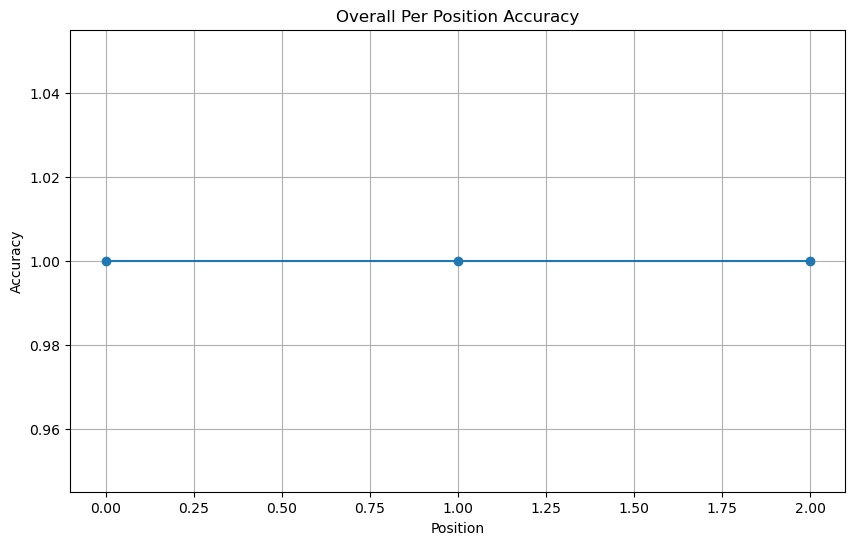

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean             1.0
    test_overall_seq_acc                  1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[]


In [76]:
# test on pure fact, make sure the model achieves 100% accuracy
trainer.test(model=lit_model, dataloaders=train_dl_fact_test)
reverse_vocab_map = {idx: vocab for vocab, idx in vocab_map.items()}
print(lit_model.mismatched_sequences)

### "finetune" on mixture dataset: 1/3 fact 1/3 counterfactual 1/3 robustness


In [77]:
# finetune on mixture dataset: 1/3 fact 1/3 counterfactual 1/3 robustness


wandb_project = 'controllability_robustness' # NOTE
group_name = 'No Validation Set' # NOTE
run_name =  datetime.now().strftime("%Y-%m-%d--%H:%M:%S")# NOTE
run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    config={'group': group_name, **model_args}) # NOTE

wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
# wandb_logger = None
logger = wandb_logger if wandb_log else None


trainer = L.Trainer(
    max_epochs=args.n_epochs, enable_checkpointing=True, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=logger,
    )

trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=validation_dataloaders)

/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/rw686/.conda/envs/memory/lib/python3.11/site-p ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /gpfs/radev/project/lafferty/rw686/Controllability-and-Robustness/experiments/lightning_logs/version_18788/checkpoints exists and is not empty.

  | Name  | Type          | Params
--------------

num decayed parameter tensors: 11, with 411,904 parameters
num non-decayed parameter tensors: 17, with 3,391 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/rw686/.conda/envs/memory/lib/python3.11/site-p ...
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the 

Testing: |          | 0/? [00:00<?, ?it/s]

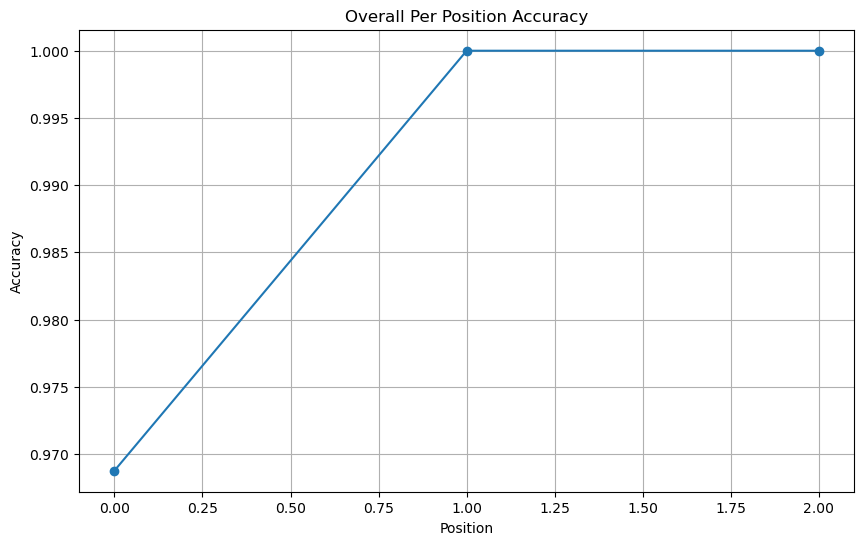

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9895833134651184
    test_overall_seq_acc                0.96875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'input': array([55, 56, 58, 31, 51]), 'predicted': array([31, 59, 60]), 'target': array([ 7, 59, 60])}, {'input': array([55, 56, 58, 43, 52]), 'predicted': array([48, 59, 60]), 'target': array([42, 59, 60])}, {'input': array([55, 56, 58, 35, 52]), 'predicted': array([17, 59, 60]), 'target': array([46, 59, 60])}, {'input': array([55, 56, 58, 29, 50]), 'predicted': array([ 7, 59, 60]), 'target': array([ 6, 59, 60])}]


In [79]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}

# model performance on the pure fact pretraining set
trainer.test(model=lit_model, dataloaders=train_dl_fact_test)
print(lit_model.mismatched_sequences)
# model performance on the validation set
lit_model.mismatched_sequences.clear()


In [ ]:
# validation set mistake reasons
print(lit_model.val_pred_mistakes_reason)
pred_mistakes_fact_reason_train_w_mxiture = lit_model.val_pred_mistakes_reason
# Plot each series with a different color
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  
reasons = pred_mistakes_fact_reason_train_w_mxiture[0].keys()
for reason in reasons:
    plt.figure(figsize=(10, 6))

    for idx, (key, values) in enumerate(pred_mistakes_fact_reason_train_w_mxiture.items()):
        if key <=2:
            dataname = f'Controllability {key+1}'
        else:
            dataname = f'Robustness {key-2}'
        plt.plot(values[reason], label=dataname, color=colors[idx % len(colors)])

    plt.xlabel('Epoch')
    plt.ylabel('Proportion')
    plt.title(f'Proportion of mistakes affected by {reason}')
    plt.legend()
    plt.show()


defaultdict(<function LitLanguageModel.__init__.<locals>.<lambda> at 0x14dc04afc360>, {})


## Test on counterfactual context

In [80]:
def decode_sequence(seq, reverse_vocab_map):
    return ' '.join([reverse_vocab_map[idx] for idx in seq])

def mismatch_seq_print(mismatch, reverse_vocab_map, max_examples=3):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}\n")

Testing: |          | 0/? [00:00<?, ?it/s]

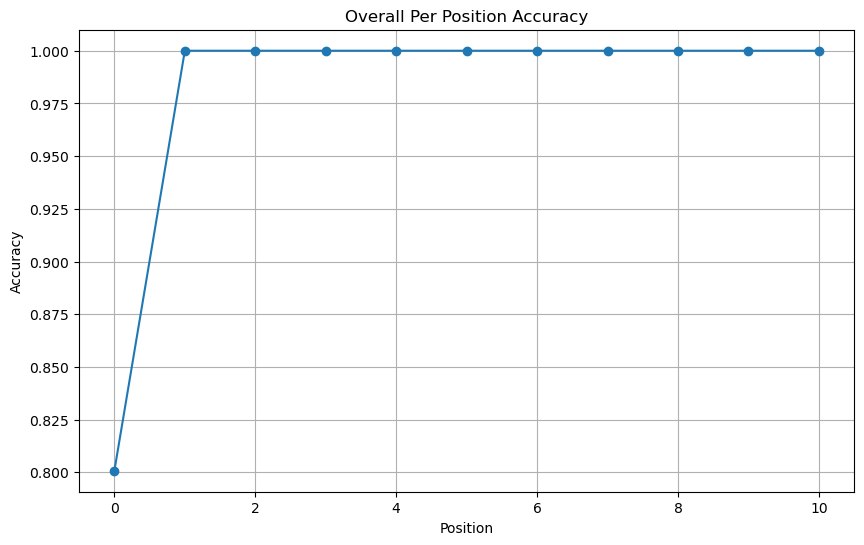

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9818891882896423
    test_overall_seq_acc              0.80078125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N7 R1 N5 <SEP> </CTX> <QUERY> N7 R1
Predicted: N3 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N5 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N32 R0 N49 <SEP> </CTX> <QUERY> N32 R0
Predicted: N11 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N49 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N9 R0 N6 <SEP> </CTX> <QUERY> N9 R0
Predicted: N13 </QUERY> <EOS>

Testing: |          | 0/? [00:00<?, ?it/s]

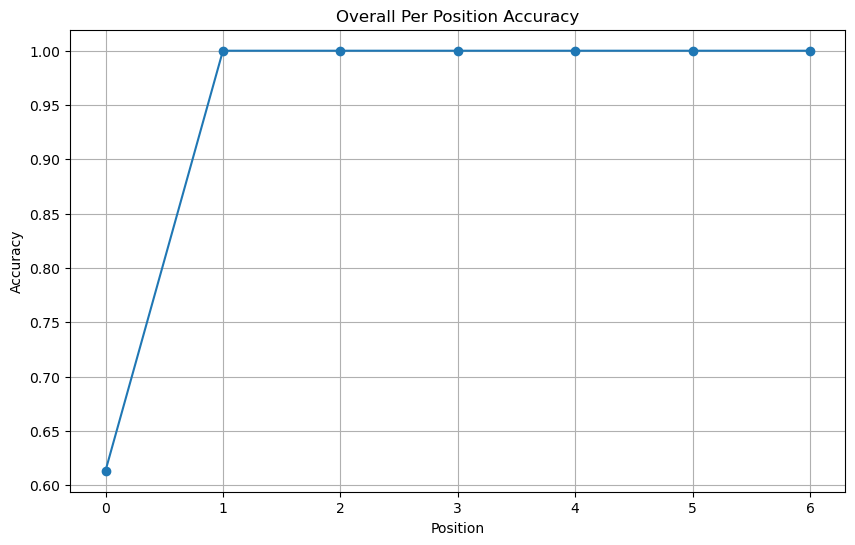

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9447544813156128
    test_overall_seq_acc              0.61328125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N11 R3 N14 <SEP> N6 R1 N23 <SEP> </CTX> <QUERY> N6 R1
Predicted: N43 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N23 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N41 R0 N26 <SEP> N36 R0 N48 <SEP> </CTX> <QUERY> N36 R0
Predicted: N42 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N48 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N17 R0 N27 <SEP> N4 R1 N33 <SEP> </CTX> <QUERY> N4 R1
Predicted: N17 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N33 </QU

Testing: |          | 0/? [00:00<?, ?it/s]

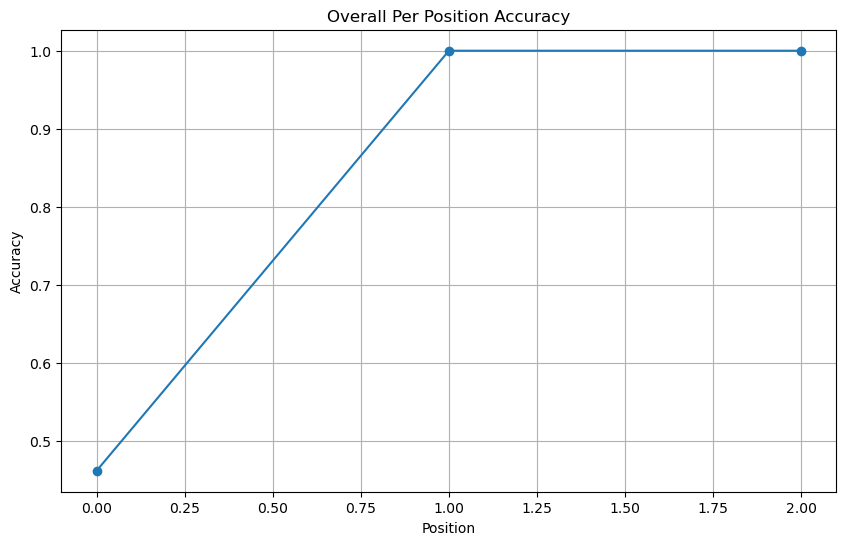

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.8206380009651184
    test_overall_seq_acc             0.4619140625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N21 R4 N44 <SEP> N33 R0 N1 <SEP> N15 R0 N22 <SEP> </CTX> <QUERY> N33 R0
Predicted: N44 </QUERY> <EOS>
Target: N1 </QUERY> <EOS>

Input: <CTX> N2 R2 N23 <SEP> N7 R2 N6 <SEP> N15 R1 N20 <SEP> </CTX> <QUERY> N2 R2
Predicted: N28 </QUERY> <EOS>
Target: N23 </QUERY> <EOS>

Input: <CTX> N23 R2 N1 <SEP> N44 R4 N21 <SEP> N8 R1 N16 <SEP> </CTX> <QUERY> N8 R1
Predicted: N44 </QUERY> <EOS>
Target: N16 </QUERY> <EOS>



In [81]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_1)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_2)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_control_3)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)




## Test on Robustness 

Testing: |          | 0/? [00:00<?, ?it/s]

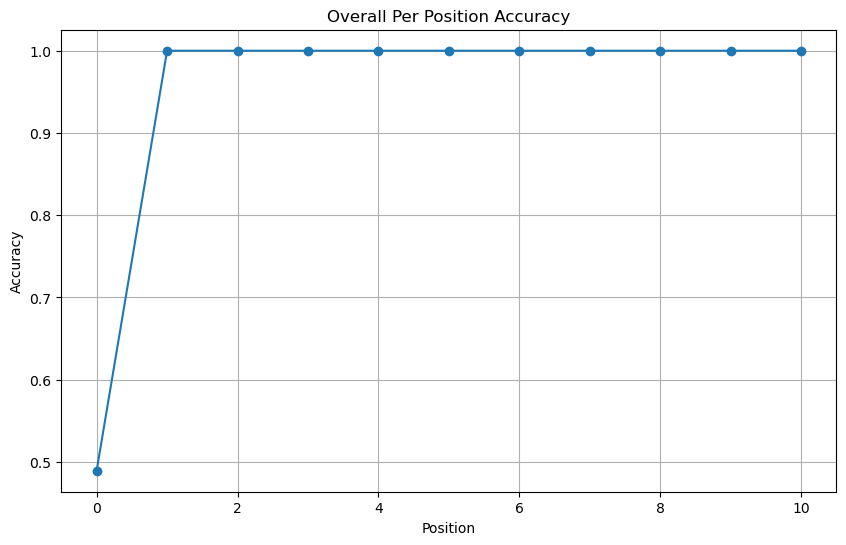

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9535688757896423
    test_overall_seq_acc             0.4892578125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N33 R4 N41 <SEP> </CTX> <QUERY> N9 R3
Predicted: N19 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N10 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N20 R4 N45 <SEP> </CTX> <QUERY> N5 R0
Predicted: N45 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target: N10 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N13 R1 N38 <SEP> </CTX> <QUERY> N20 R1
Predicted: N38 </QUERY

Testing: |          | 0/? [00:00<?, ?it/s]

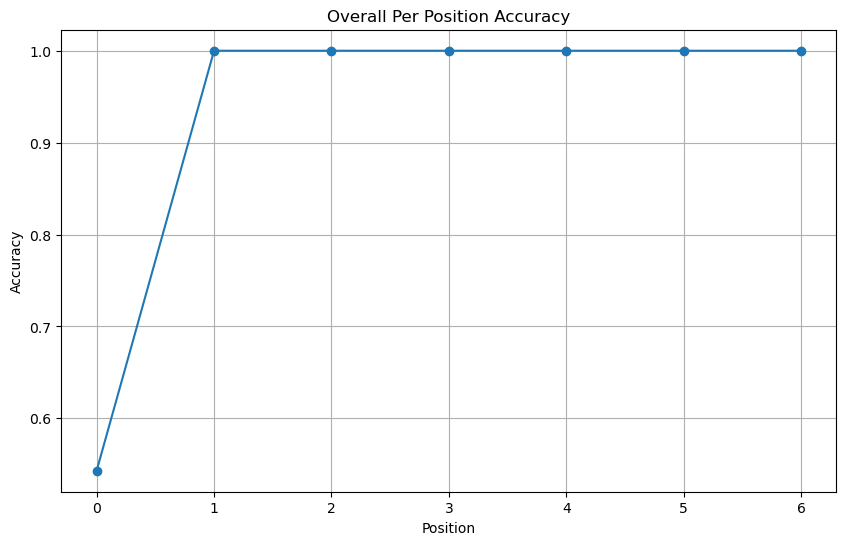

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.9347098469734192
    test_overall_seq_acc              0.54296875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N37 R1 N21 <SEP> N43 R2 N42 <SEP> </CTX> <QUERY> N37 R4
Predicted: N21 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N24 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N8 R1 N49 <SEP> N37 R1 N21 <SEP> </CTX> <QUERY> N31 R1
Predicted: N37 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>

Input: <CTX> N33 R0 N44 <SEP> N17 R4 N43 <SEP> </CTX> <QUERY> N29 R0
Predicted: N44 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD>
Target: N6 </Q

/home/rw686/.conda/envs/memory/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

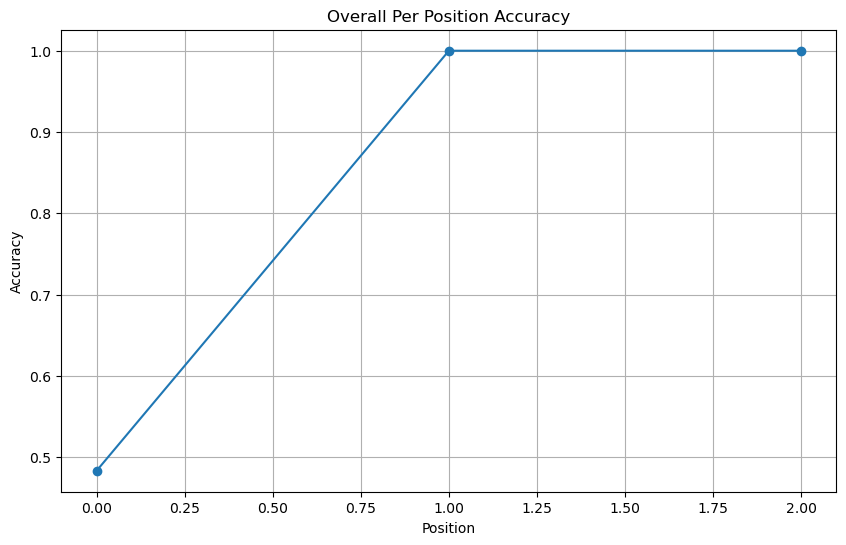

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
test_overall_per_pos_acc_mean     0.8277994990348816
    test_overall_seq_acc             0.4833984375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Input: <CTX> N37 R1 N21 <SEP> N8 R1 N49 <SEP> N3 R1 N35 <SEP> </CTX> <QUERY> N18 R4
Predicted: N28 </QUERY> <EOS>
Target: N47 </QUERY> <EOS>

Input: <CTX> N45 R1 N42 <SEP> N30 R3 N0 <SEP> N6 R4 N37 <SEP> </CTX> <QUERY> N18 R2
Predicted: N37 </QUERY> <EOS>
Target: N45 </QUERY> <EOS>

Input: <CTX> N16 R4 N41 <SEP> N28 R1 N18 <SEP> N1 R4 N34 <SEP> </CTX> <QUERY> N11 R3
Predicted: N49 </QUERY> <EOS>
Target: N14 </QUERY> <EOS>

Input: <CTX> N1 R2 N14 <SEP> N9 R3 N10 <SEP> N2 R4 N17 <S

In [82]:
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_1)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map,max_examples=6)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_2)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map, max_examples=6)

lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_robust_3)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map, max_examples=6)



In [ ]:
def context_extract(dataloader):
    context_tuples_mixture_train =[]
    for x, y in dataloader:
        for i in range(x.size(0)):
            for j in range(x.size(1)):
                if x[i,j] == vocab_map['<CTX>']:
                    context_tuples_mixture_train.append(x[i,j+1: j+4])
                elif x[i,j] == vocab_map['<SEP>'] and x[i,j+1] != vocab_map['</CTX>']:    
                    context_tuples_mixture_train.append(x[i,j+1: j+4])
                elif x[i,j] == vocab_map['</CTX>']:
                    break
    return context_tuples_mixture_train

def query_extract(dataloader):
    query_tuples_mixture_train =[]
    for x, y in dataloader:
        for i in range(x.size(0)):
            for j in range(x.size(1)):
                if x[i,j] == vocab_map['<QUERY>']:
                    query_tuples_mixture_train.append(x[i,j+1: j+4])
                    break
    return query_tuples_mixture_train

    
#print(context_extract(train_dl))

def context_affected_prediction(lit_model,context_tuples_mixture_train, query_tuples_mixture_train):
    
    if not lit_model.mismatched_sequences:
        return None
    counter_own_context = 0
    counter_other_context = 0
    counter_query = 0
    counter_query_ro = 0
    for mismatch in lit_model.mismatched_sequences:
        input_seq = mismatch['input']
        predicted_seq = mismatch['predicted']
        target_seq = mismatch['target']
        
        # find the object and relation in the input sequence
        context_examples = []
        for i in range(len(input_seq)):
            # organize examples from context
            if input_seq[i] == vocab_map['<CTX>']:
                context_examples.append(input_seq[i+1:i+4])
            elif input_seq[i] == vocab_map['<SEP>'] and input_seq[i] != vocab_map['</CTX>']:
                context_examples.append(input_seq[i+1:i+4])
                


            elif input_seq[i] == vocab_map['<QUERY>']:
                sub = input_seq[i+1]
                rel = input_seq[i+2]
                obj_target = target_seq[0]
                obj_pred = predicted_seq[0]
                if (sub, rel, obj_pred) in context_tuples_mixture_train:
                    #print("affected by some context in mixture training",sub, rel, obj_pred)
                    counter_other_context+=1
                
                for (s,r,o) in context_examples:
                    if (r == rel) and (o == obj_pred):
                    #print("affected by its own context",input_seq)   
                        counter_own_context+=1
                        break

                if (sub, rel, obj_pred) in query_tuples_mixture_train:
                    counter_query+=1

                for (s,r,o) in query_tuples_mixture_train:
                    if (r == rel) and (o == obj_pred):
                        counter_query_ro +=1
                        break
                break
        num_mistakes = len(lit_model.mismatched_sequences)
    return counter_own_context/num_mistakes, counter_other_context/num_mistakes, counter_query/num_mistakes, counter_query_ro/num_mistakes

context_tuples_mixture_train = context_extract(train_dl)
query_tuples_mixture_train = query_extract(train_dl)
